# NMIST DATASET
## Henry Salgado
# June 2025


Based on tutorial: https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Multi-input%20Gradient%20Explainer%20MNIST%20Example.html

In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Image shape: torch.Size([1, 28, 28])
Label: 2


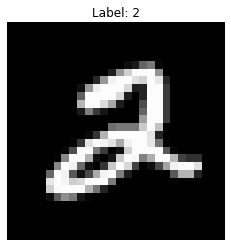

In [ ]:
image, label = trainset[5]
print("Image shape:", image.shape) 
print("Label:", label)


plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [164]:
class FeedforwardCNN(nn.Module):
    def __init__(self):
        super(FeedforwardCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FeedforwardCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [166]:
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

       
        optimizer.zero_grad()

      
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")


Epoch 1, Loss: 0.2865767380597987
Epoch 2, Loss: 0.07272878888004553
Epoch 3, Loss: 0.054306794287833464
Epoch 4, Loss: 0.0442937516224092
Epoch 5, Loss: 0.03747455341774208


In [167]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 98.41%


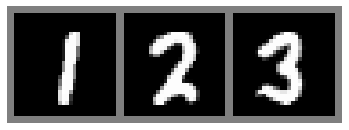

Labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]


In [168]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images[:3]))
print("Labels:", labels[:20].tolist())


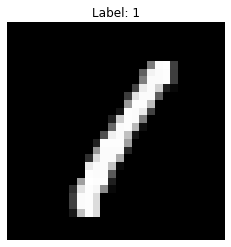

In [169]:
image, label = trainset[3]
image = image.unsqueeze(0).to(device) 


plt.imshow(image.squeeze(), cmap="gray")  
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


White = high activation

Black = low activation

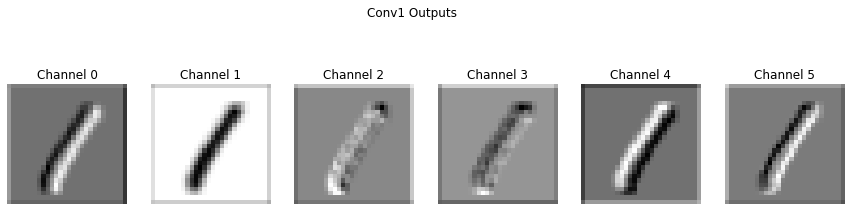

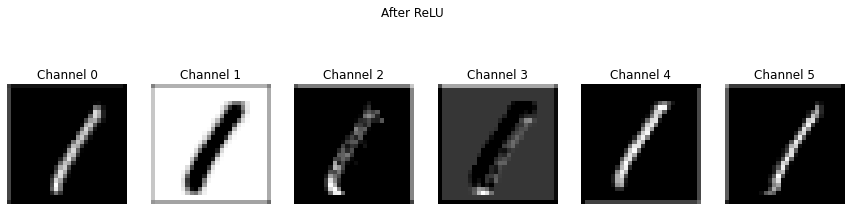

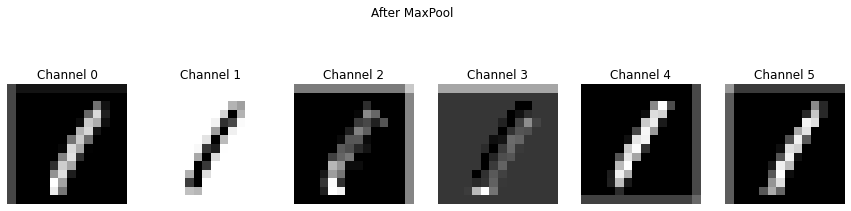

In [170]:


with torch.no_grad():
    act1 = model.conv1(image)       
    act1_relu = model.relu1(act1)   
    act1_pool = model.pool1(act1_relu)


import matplotlib.pyplot as plt

def plot_activations(activation, title="Activations"):
    num_features = activation.shape[1]
    fig, axes = plt.subplots(1, min(6, num_features), figsize=(15, 4))
    for i in range(min(6, num_features)):
        ax = axes[i]
        ax.imshow(activation[0, i].cpu(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Channel {i}')
    fig.suptitle(title)
    plt.show()


plot_activations(act1, title="Conv1 Outputs")
plot_activations(act1_relu, title="After ReLU")
plot_activations(act1_pool, title="After MaxPool")


In [171]:
import torch.nn.functional as F

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        logits = self.model(x)
        return F.softmax(logits, dim=1)  # SHAP expects probabilities


In [172]:
import shap
import torch

# Select small background and test sets
background = next(iter(trainloader))[0][:100].to(device)  # 100 images from training set
samples_to_explain = next(iter(testloader))[0][:10].to(device)  # 10 test images

# Wrap the trained model
wrapped_model = WrappedModel(model).to(device)
wrapped_model.eval()


WrappedModel(
  (model): FeedforwardCNN(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=64, out_features=10, bias=True)
  )
)

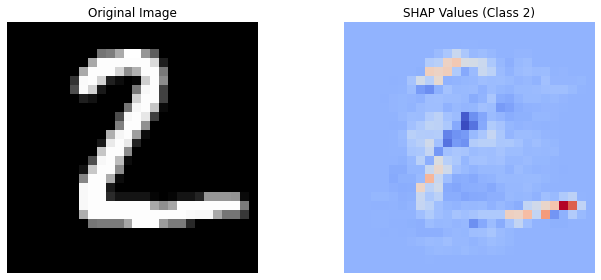

In [195]:
import matplotlib.pyplot as plt


sample_idx = 1
class_idx = 2


img_np = samples_to_explain[sample_idx].detach().cpu().numpy().squeeze()


shap_img = shap_values[class_idx][sample_idx].squeeze()


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(shap_img, cmap='coolwarm')  # Red = negative, Blue = positive
plt.title(f"SHAP Values (Class {class_idx})")
plt.axis('off')

plt.tight_layout()
plt.show()


In [174]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [175]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [176]:
model = Sequential()

model.add(Conv2D(
    8,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(28, 28, 1)
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


model.fit(x_train, y_train_cat, epochs=4, batch_size=128, validation_split=0.1)

score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/4
422/422 [==============================] - 5s 10ms/step - loss: 0.5032 - accuracy: 0.8473 - val_loss: 0.1521 - val_accuracy: 0.9580
Epoch 2/4
422/422 [==============================] - 4s 10ms/step - loss: 0.2453 - accuracy: 0.9276 - val_loss: 0.1048 - val_accuracy: 0.9692
Epoch 3/4
422/422 [==============================] - 4s 10ms/step - loss: 0.1922 - accuracy: 0.9420 - val_loss: 0.0849 - val_accuracy: 0.9757
Epoch 4/4
422/422 [==============================] - 4s 10ms/step - loss: 0.1668 - accuracy: 0.9498 - val_loss: 0.0714 - val_accuracy: 0.9792
Test loss: 0.08287598937749863
Test accuracy: 0.9736999869346619


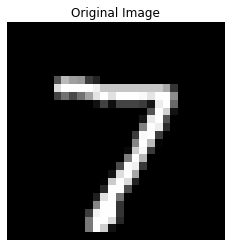

In [177]:
import numpy as np
import matplotlib.pyplot as plt

sample_image = x_test[0].reshape(1, 28, 28, 1)

plt.imshow(sample_image[0, :, :, 0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 39ms/step


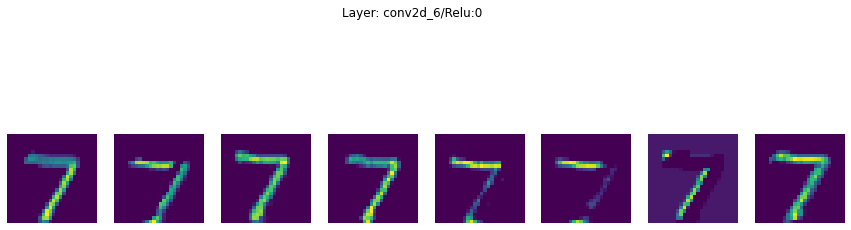

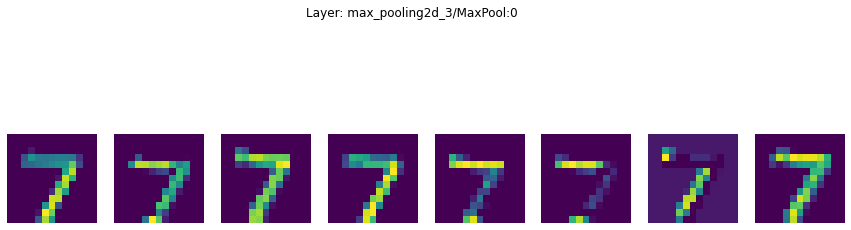

In [178]:
from tensorflow.keras.models import Model


layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(sample_image)

import matplotlib.pyplot as plt

def display_activation(activation, title, max_images=8):
    num_filters = min(activation.shape[-1], max_images)
    plt.figure(figsize=(15, 5))
    for i in range(num_filters):
        plt.subplot(1, num_filters, i + 1)
        plt.imshow(activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


for layer_output, layer in zip(activations, activation_model.outputs):
    display_activation(layer_output, title=f"Layer: {layer.name}")



In [179]:
import shap

x_sample = shap.sample(x_train, 500)


explainer = shap.GradientExplainer(model, data=x_sample)


shap_values = explainer.shap_values(x_test[:4])

10


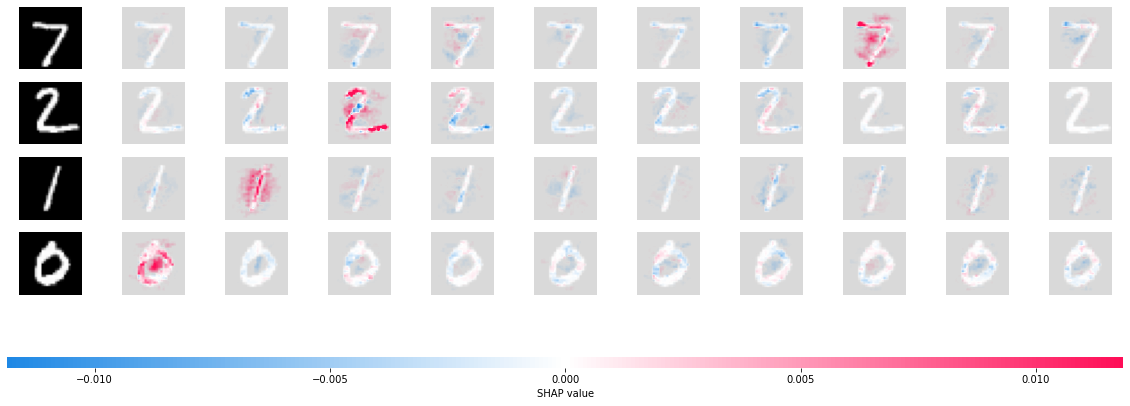

In [180]:
print(len(shap_values))
shap.image_plot(shap_values, x_test[:4])